# XAI 2025 TP5 

## PostHoc - Image data

Author: Arthur Babey

Due: 13.05.2025, 23h59

- Professor: Carlos Peña (<a href="mailto:carlos.pena@heig-vd.ch">carlos.pena@heig-vd.ch</a>)
- Assistant 2025: Arthur Babey (<a href="mailto:arthur.babey@heig-vd.ch">arthur.babey@heig-vd.ch</a>)


Date: Spring 2025

* You will need to fill code and answer questions in this notebook

You have a folder called **XAI_TP5_2025_MATERIAL** structured like this :

**XAI_TP5_2025_MATERIAL**/

	data/
		skin-lesion/
            test/
                empty : download it             
            metadata/
                csv with metadata info
            label/
                csv with label info
        
	models/
            model.pth/
                model's weight

            train_metrics.csv

            confusion_matrix.png            
            
            
    XAI_TP5_2025_Image_NOM_PRENOM.ipynb
    
    scripts/
        scripts used for training, evaluation, customdataset and helpers function
            


---
- **Link to download the test set** : https://www.swisstransfer.com/d/1d795359-d947-4c90-8b24-1bba007286b0

- Place it in ./data/skin-lesion


---
# Instructions

During this TP we will use the ISIC 2019 [dataset](https://www.kaggle.com/datasets/andrewmvd/isic-2019). The dataset for ISIC 2019 contains 25,331 images available for the classification of dermoscopic images among nine different diagnostic categories:
- Melanoma
- Melanocytic nevus
- Basal cell carcinoma
- Actinic keratosis
- Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- Dermatofibroma
- Vascular lesion
- Squamous cell carcinoma
- None of the above

The dataset was splitted into and train and a test data. The full dataset is accessible on kaggle and the test dataset you will need to use here is stored in ./data/test/

You have been provided with a fine-tuned EfficientNet-B3 model for this dataset. EfficientNet-B3 is a convolutional neural network architecture that offers high classification accuracy while requiring reasonable computing power. It was introduced in the paper 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks' by Tan et al. (2019). If you are interested, you can find more details about the architecture in the paper by following this [link](https://arxiv.org/abs/1905.11946).

We also give you multiple function that will make your life easier to plot, make inference, plot on test images. They are described in ./scripts/helpers.py.

---

You will need to complete code, generate plot and answer questions


Goal :

0. Explore : explore the dataset and the model performance
1. Use XAI's method to generate explanation 
2. Expain model's behaviour using PostHoc methods

---

To install the required libraries, run the following commands:

```bash
pip install torch torchvision
pip install captum
pip install efficientnet_pytorch
```

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from efficientnet_pytorch import EfficientNet
from captum.attr import LayerGradCam
from torchvision.transforms.functional import to_pil_image

from scripts.evaluate import evaluate
from scripts.helpers import *
from scripts.custom_dataset import CustomImageDataset

In [2]:
# setting paths 

home_path = os.getcwd()

# PATHs 

data_path = os.path.join(home_path, "data", "skin-lesion")
test_dir_path = os.path.join(data_path, "test")
label_test_path = os.path.join(data_path, "label", "label_test.csv")
model_path = os.path.join(home_path, "models")

## 0. Explore dataset and model


- First we load the trained model and the test dataset

- Then we can evaluate it, the run is quite long so you don't have to run it

- The evaluation metrics are shown and a confusion matrix is ploted


In [3]:
# set device cuda, MPS or cpu
device = get_device()

# Load model 
model = EfficientNet.from_pretrained("efficientnet-b3", num_classes=8).to(device)
state = torch.load(os.path.join(model_path, "model.pth"), map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# load the test set
test_dataset = CustomImageDataset(csv_path=label_test_path, data_path=test_dir_path, transform=transforms_eval())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# class names
class_names = ["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/tux/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


100%|██████████| 47.1M/47.1M [00:01<00:00, 26.5MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
# you do NOT need to rerun this cell
#f1_test, acc_test, conf = evaluate(model=model, batch_size = 32)

Accuracy: 0.8489
F1 Score (macro): 0.7252
Confusion Matrix:
[[ 366  175   14   16    0    6    0    4]
 [ 127 1951   15    5    3    8    3    4]
 [  18   27  260   11    0    2    2    9]
 [   6   11   17   41    0    2    0    3]
 [   0    3    0    0  386    0    0    0]
 [   3    4    3    0    0   24    0    1]
 [   1    3    5    0    0    0   27    0]
 [   8    7   13    8    0    3    0   36]]


---
Let's have a look at the confusion matrix : 

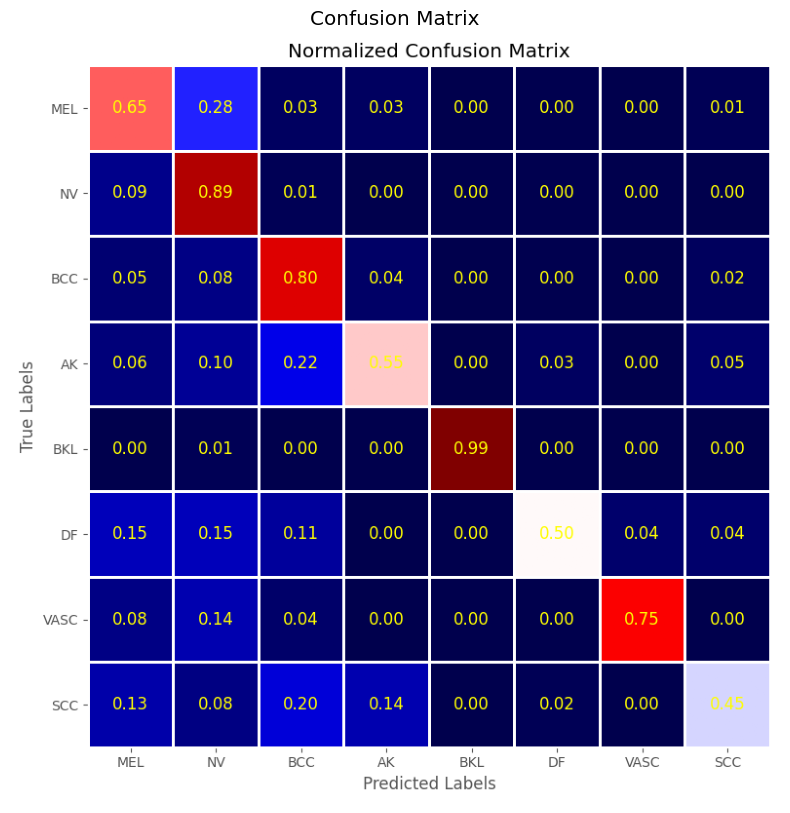

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(model_path, "confusion_matrix.png")))
plt.axis('off')
plt.title("Confusion Matrix")
plt.show()

---
We can have a look at some training metrics 

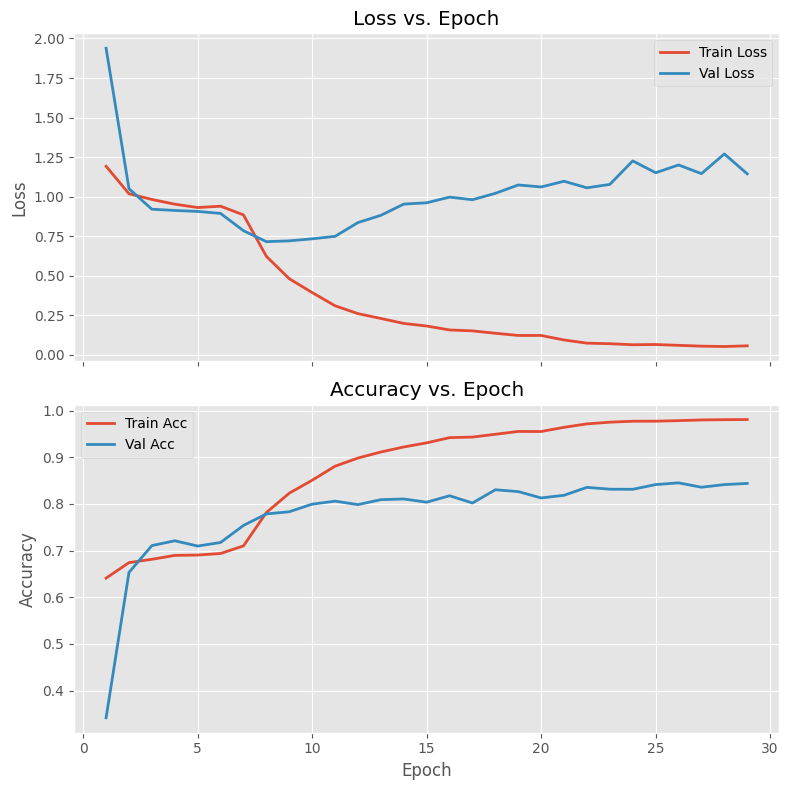

In [5]:
# load data
val_loss_df   = pd.read_csv(os.path.join(model_path, "val_loss.csv"))
train_loss_df = pd.read_csv(os.path.join(model_path, "train_loss.csv"))
val_acc_df    = pd.read_csv(os.path.join(model_path, "val_acc.csv"))
train_acc_df  = pd.read_csv(os.path.join(model_path, "train_acc.csv"))

# extract metrics
train_loss = train_loss_df['train_loss'].values
val_loss   = val_loss_df['val_loss'].values
train_acc  = train_acc_df['train_acc'].values
val_acc    = val_acc_df['val_acc'].values
epochs     = range(1, len(train_loss) + 1)

# create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# plot loss
ax1.plot(epochs, train_loss, label='Train Loss', linewidth=2)
ax1.plot(epochs, val_loss,   label='Val Loss',   linewidth=2)
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. Epoch')
ax1.legend()
ax1.grid(True)

# plot accuracy
ax2.plot(epochs, train_acc, label='Train Acc', linewidth=2)
ax2.plot(epochs, val_acc,   label='Val Acc',   linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs. Epoch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Questions : 

Have a look on the dataset description, it is a balance dataset ? Is there a a class that is way more represented than the other ? if yes which one ? Assume that the train/test split is random so the frequency in the test set is the same than in the whole dataset

*Answer:* the dataset is not balanced. 'NV' (Melanocytic nevus) diagnostic class has a much larger number of images (over 12,000) compared to other classes. Given that the train/test split is random, the test set would also reflect this imbalance in class distribution.

Identify a potential prediction issue regarding the balance of the dataset by looking at the confusion matrix (be precise).

*Answer:*

Comment the evaluation result, accuracy, f1 score and the confusion matrix ?

*Answer:* 

Comment the learning curves ? the model is overfitting ?

*Answer:* 
   

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /5 </b>
</div>

Commentaires: 

---

Let's have a look at some examples : 

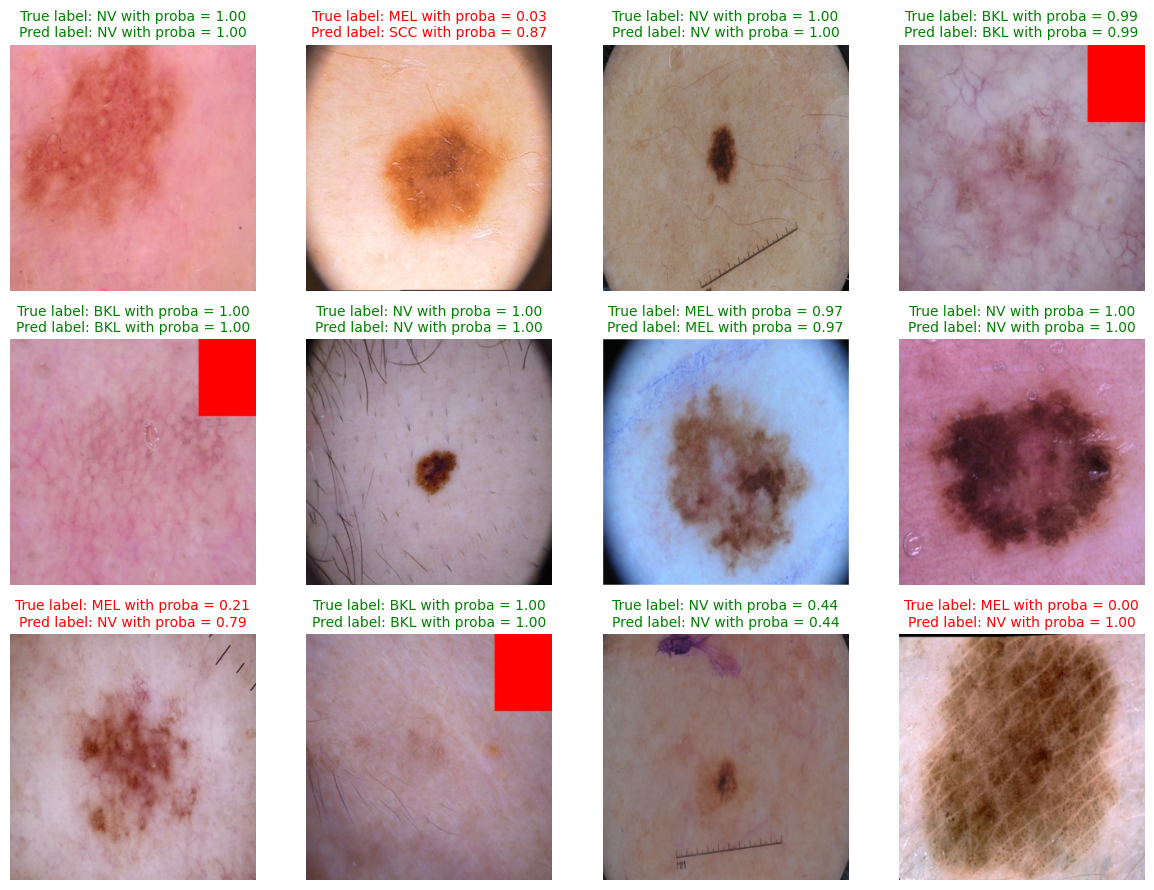

In [8]:
indices = np.random.randint(0, 1400, size=12)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i, index in enumerate(indices):
    row = i // 4
    col = i % 4
    
    true_label, predicted_label, true_prob, predicted_prob = inference(model, index, test_dataset)       
    img = to_plot(index, test_dataset)
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    if true_prob == predicted_prob:
        color = 'green'
    else:
        color = 'red'
    axes[row, col].set_title(
        f"True label: {true_label} with proba = {true_prob:.2f}\nPred label: {predicted_label} with proba = {predicted_prob:.2f}",
        color=color,
        fontsize=10
    )

plt.tight_layout()
plt.show()

---

Now let's have a look at the model architecture, it is fine tune efficient net model b3 model. In the next cell we can see all the layers name and it's architecture. You can look there to have layer name information that you will need later

In [9]:
print(model)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

### Questions

- **Q1:**. When looking at the images and the model’s predictions, what do you think might cause misclassifications? Can you identify important regions in the images that may affect the model’s decision?

- **Q2:** As you can see, interpreting medical images is not always straightforward. In your own words, why is it important to have domain expertise when analyzing XAI results?

- **Q3:** Can you briefly describe the structure of the model (an efficiennet model)? You don’t need to be exhaustive—just explain the main parts and how the model works in general.



---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /4 </b>
</div>

Commentaires: 

## 1. PostHoc Explanations using Captum


- To make predictions with a neural network, the data input is passed through many layers of multiplication with the learned weights and through non-linear transformations. A single prediction can involve millions of mathematical operations. There is no chance that we humans can follow the exact mapping from data input to prediction.

- Some XAI posthoc methods can help to interpate a neural network result and we will parcours some of them in this section. To do so we will use the [**captum package**](https://captum.ai/)  that put together multiple xai methods including some for vision task for pytorch model. 


### Grad-CAM Exercise

- Grad-CAM is an XAI method that highlights the regions most important to a convolutional neural network’s decision. We provide helper functions to compute and plot Grad-CAM for any input tensor, its label, and a chosen convolutional layer (typically one near the end of the network for best spatial resolution).

In [11]:
def apply_gradcam(model, input_tensor, target_class, layer):
    model.eval()
    gradcam = LayerGradCam(model, layer)
    attr = gradcam.attribute(input_tensor, target=target_class)
    up = F.interpolate(attr, size=input_tensor.shape[2:], mode='bilinear')
    up = up.squeeze().cpu().detach().numpy()
    up = (up - up.min()) / (up.max() - up.min() + 1e-8)  # Normalize to [0, 1]
    return up

def overlay_heatmap(input_tensor, attribution, alpha=0.5):
    img = to_pil_image(input_tensor.squeeze().cpu())

    if torch.is_tensor(attribution):
        hm = attribution.squeeze().cpu().numpy()
    else:
        hm = attribution

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")
    heatmap = axes[1].imshow(hm, cmap="jet", alpha=alpha)
    axes[1].imshow(img, alpha=1 - alpha)
    axes[1].set_title("Attribution")
    axes[1].axis("off")
    
    # Add color bar
    cbar = fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label("Attribution Intensity", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

Let's see the results on a random images

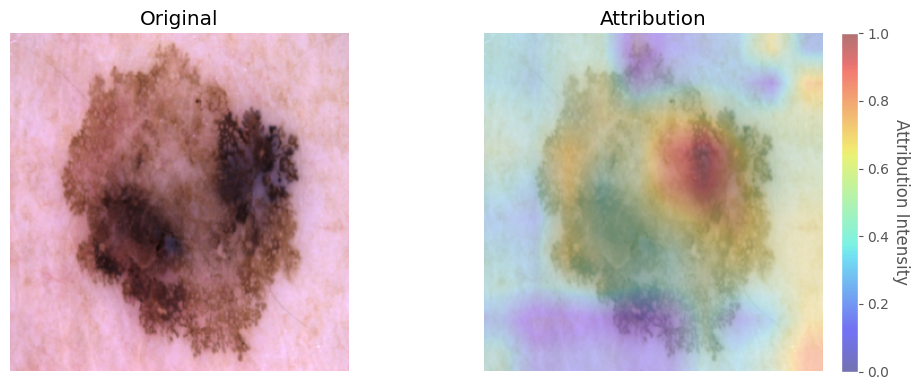

In [12]:
idx = 1234 # random index of the test set
img_tensor, class_idx = test_dataset[idx]
img_tensor = img_tensor.unsqueeze(0).to(device)
class_idx = class_idx.argmax().item()

layer = model._conv_head

gc_attr = apply_gradcam(model, img_tensor, class_idx, layer)
overlay_heatmap(img_tensor, gc_attr)

### Grad-CAM Exploration

1. Pick **one image** from the test set (any index you like).

2. Choose:
   - A **target convolutional layer** (usually one near the end of the model).
   - A **target class** to explain (you can use the predicted class or try another one).

3. Run **Grad-CAM** on that image.

4. Then answer:
   - Why did you choose this layer and class?
   - Which parts of the image are highlighted in the heat-map?
   - Why do you think the model focused on those regions?

If you need help checking labels or predictions, you can use these small helpers function:

```python
from scripts.helpers import idx_to_predicted_label, idx_to_true_label, idx_to_proba
``` 

For example : 

In [13]:
print(idx_to_predicted_label(303, test_dataset, model))

BCC


In [14]:
print(idx_to_true_label(303, test_dataset))

NV


In [15]:
print(idx_to_proba(303, test_dataset, model))

1. BCC: 0.9703 (logit: 8.6705)
2. NV: 0.0296 (logit: 5.1813)
3. MEL: 0.0001 (logit: -0.9820)
4. VASC: 0.0000 (logit: -2.7978)
5. SCC: 0.0000 (logit: -3.0762)
6. AK: 0.0000 (logit: -5.9811)
7. BKL: 0.0000 (logit: -6.4157)
8. DF: 0.0000 (logit: -11.2092)
(tensor([[9.7030e-01, 2.9620e-02, 6.2359e-05, 1.0146e-05, 7.6807e-06, 4.2056e-07,
         2.7232e-07, 2.2557e-09]]), tensor([[ -0.9820,   5.1813,   8.6705,  -5.9811,  -6.4157, -11.2092,  -2.7978,
          -3.0762]]))


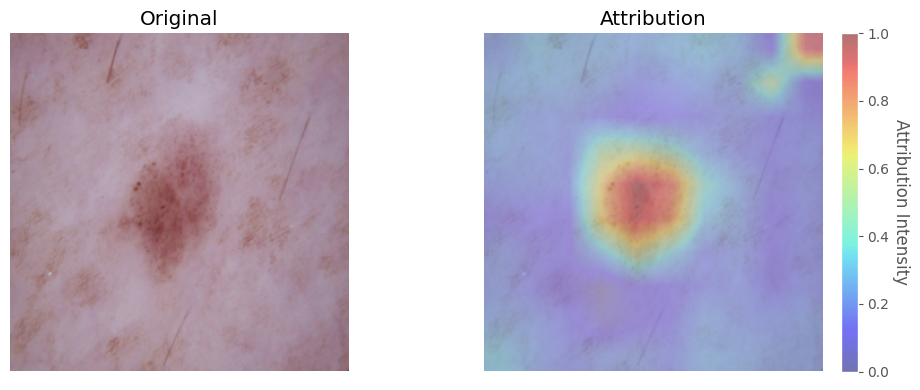

In [ ]:
# YOUR CODE HERE
idx = 666 # random index of the test set
img_tensor, class_idx = test_dataset[idx]
img_tensor = img_tensor.unsqueeze(0).to(device)
class_idx = class_idx.argmax().item()

layer = model._conv_head

gc_attr = apply_gradcam(model, img_tensor, class_idx, layer)
overlay_heatmap(img_tensor, gc_attr)

In [21]:
class_names[class_idx]

'NV'

*Answers* : 

- Why did you choose this layer and class? We chose it because it's the last layer of the convolution part, it was the predicted class (NV)
- Which parts of the image are highlighted in the heat-map?
- Why do you think the model focused on those regions?

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /5 </b>
</div>

Commentaires: 

## Saliency and Occlusion

Let's use others explainers from the Captum package, saliency map and occlusion. 

Your task : 

1. **Load the image** at index `836` from the test set.  
   Run the model on it and print the output probabilities.

2. **Answer the following questions**:  
   - What is the **true label** of this image?  
   - What is the **predicted label** by the model?

3. **Use two explanation methods (no Grad-CAM)**:

   Saliency (Vanilla Gradient)
   - This method shows which pixels have the biggest effect on the model's prediction.
   - Brighter areas = more important for the predicted class.
   - **Q1:** Which part of the image is most highlighted in the saliency map?

   Occlusion
   - This method hides small parts of the image with a grey patch and checks how the prediction changes.
   - If hiding a patch drops the score a lot → that patch was important.
   - Use a patch size of `15 x 15` and stride `8`.
   - **Q2:** Are the important areas bigger or smaller than in the saliency map?

    **Plot the results** 

4. **Compare the two methods**
   - **Q3:** Do both explanations highlight the same areas?  
   - **Q4:** Which explanation do you find more useful, and why?


In [ ]:
# YOUR CODE HERE
from captum.attr import Saliency, Occlusion

saliency = Saliency(model)

idx = 836
img_tensor, true_label_idx = test_dataset[idx]

img_tensor = img_tensor.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_tensor)

true_label = idx_to_true_label(idx, test_dataset)
pred_label = idx_to_predicted_label(idx, test_dataset, model)
print(f"True label: {true_label}")
print(f"Predicted label: {pred_label}")

True label: NV
Predicted label: NV


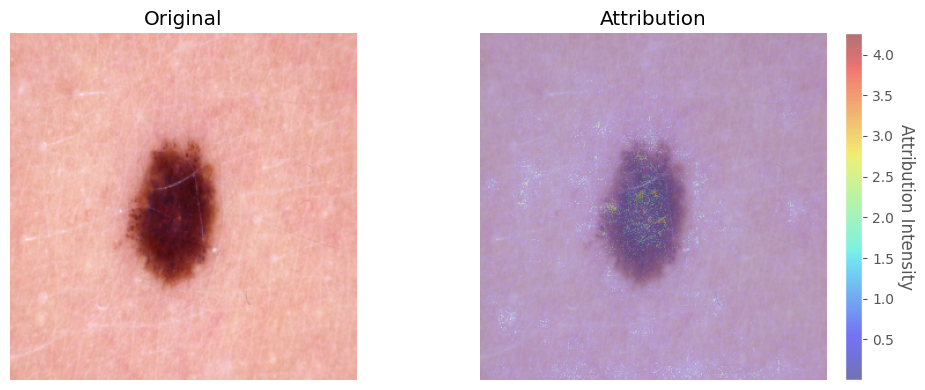

In [71]:
saliency = Saliency(model)
attributions_saliency = saliency.attribute(img_tensor, target=1)
attributions_saliency = attributions_saliency.abs().squeeze().cpu().detach()

saliency_map_2d = attributions_saliency.max(dim=0).values

overlay_heatmap(img_tensor, saliency_map_2d)

In [72]:
occlusion = Occlusion(model)

# Apply occlusion with patch size 15x15 and stride 8
attributions_occ = occlusion.attribute(
    img_tensor,
    strides=(3, 8, 8),  # (channels, height_stride, width_stride)
    sliding_window_shapes=(3, 15, 15),  # (channels, height, width)
    target=1
)

# Remove batch dimension and move to CPU
attributions_occ = attributions_occ.squeeze().cpu().detach()

# Normalize to [0, 1]
attributions_occ = (attributions_occ - attributions_occ.min()) / (attributions_occ.max() - attributions_occ.min() + 1e-8)

# Reduce from (3, H, W) → (H, W) for visualization
occlusion_map_2d = attributions_occ.max(dim=0).values

# --- Visualize ---
overlay_heatmap(img_tensor, occlusion_map_2d)

KeyboardInterrupt: 

*Answers :*

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: 8 </b>
</div>

Commentaires: 

## 2. Undersand model's behaivour 

### Question – Why does the model confuse MEL and NV?

- From the confusion matrix, we observe that the model frequently confuses **MEL** (melanoma) with **NV** (nevus).  

- Despite having many examples of MEL, it is correctly predicted only about 65% of the time.

- A significant portion of the misclassified examples comes from the confusion between MEL and NV.

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(os.path.join(model_path, "confusion_matrix.png")))
plt.axis('off')
plt.title("Confusion Matrix")
plt.show()


We will try to understand why the model is mixing these two classes using XAI posthoc methods.

You can use the next function to find example of MEL and NEV good and wrong predictions 
---

1. Choose at least **one image from each group** above.
2. Use at least **two different Captum methods** (e.g. GradCAM, Saliency, Occlusion, GuidedGradCam, GradientSHAP).
3. For each image:
   - Show the original image and the explanation map.
   - Look at what parts of the image the model is using.
   - Is the model focusing on the lesion or the background?

4. **Write a short explanation**:
   - What do you think causes the confusion between MEL and NV?
   - Do some lesions look similar?
   - Do some maps highlight the wrong areas?

Try to make a hypothesis from what you observe.

In [17]:
def find_examples(dataset, model, device, seed=42, max_trials=2000):
    import random
    random.seed(seed)
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    matches = {
        "MEL-MEL": None,
        "NV-NV": None,
        "NV-MEL": None,
        "MEL-NV": None
    }

    for idx in indices[:max_trials]:
        img, label = dataset[idx]
        true_name = label_to_names(label)

        model.eval()
        with torch.no_grad():
            logits = model(img.unsqueeze(0).to(device))
            probs = F.softmax(logits, dim=1)
            pred_idx = probs.argmax().item()
            pred_name = class_names[pred_idx]

        key = f"{true_name}-{pred_name}"
        if key in matches and matches[key] is None:
            matches[key] = idx

        if all(v is not None for v in matches.values()):
            break

    return matches


In [18]:
# YOUR CODE HERE





*Answers :*

---
*Réservé pour corrections*
<div class="alert alert-block alert-info">
<b>Corrections: /8 </b>
</div>

Commentaires: 

FIN